In [57]:
import koala as kl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import linalg as la
matplotlib.rcParams.update({ 'text.usetex': True, 'font.family': 'serif', 'font.serif': ['Computer Modern']})
from tqdm import tqdm

In [58]:
from koala import plotting as pl
from koala.pointsets import bluenoise, uniform
from koala.voronization import generate_lattice
from koala.lattice import cut_boundaries
from koala.graph_utils import remove_trailing_edges, make_dual


In [59]:

points = bluenoise(20, 60,60)
# points = bluenoise(2000)
lattice = generate_lattice(points)
from koala.graph_utils import lloyd_relaxation
lattice = lloyd_relaxation(lattice,4)


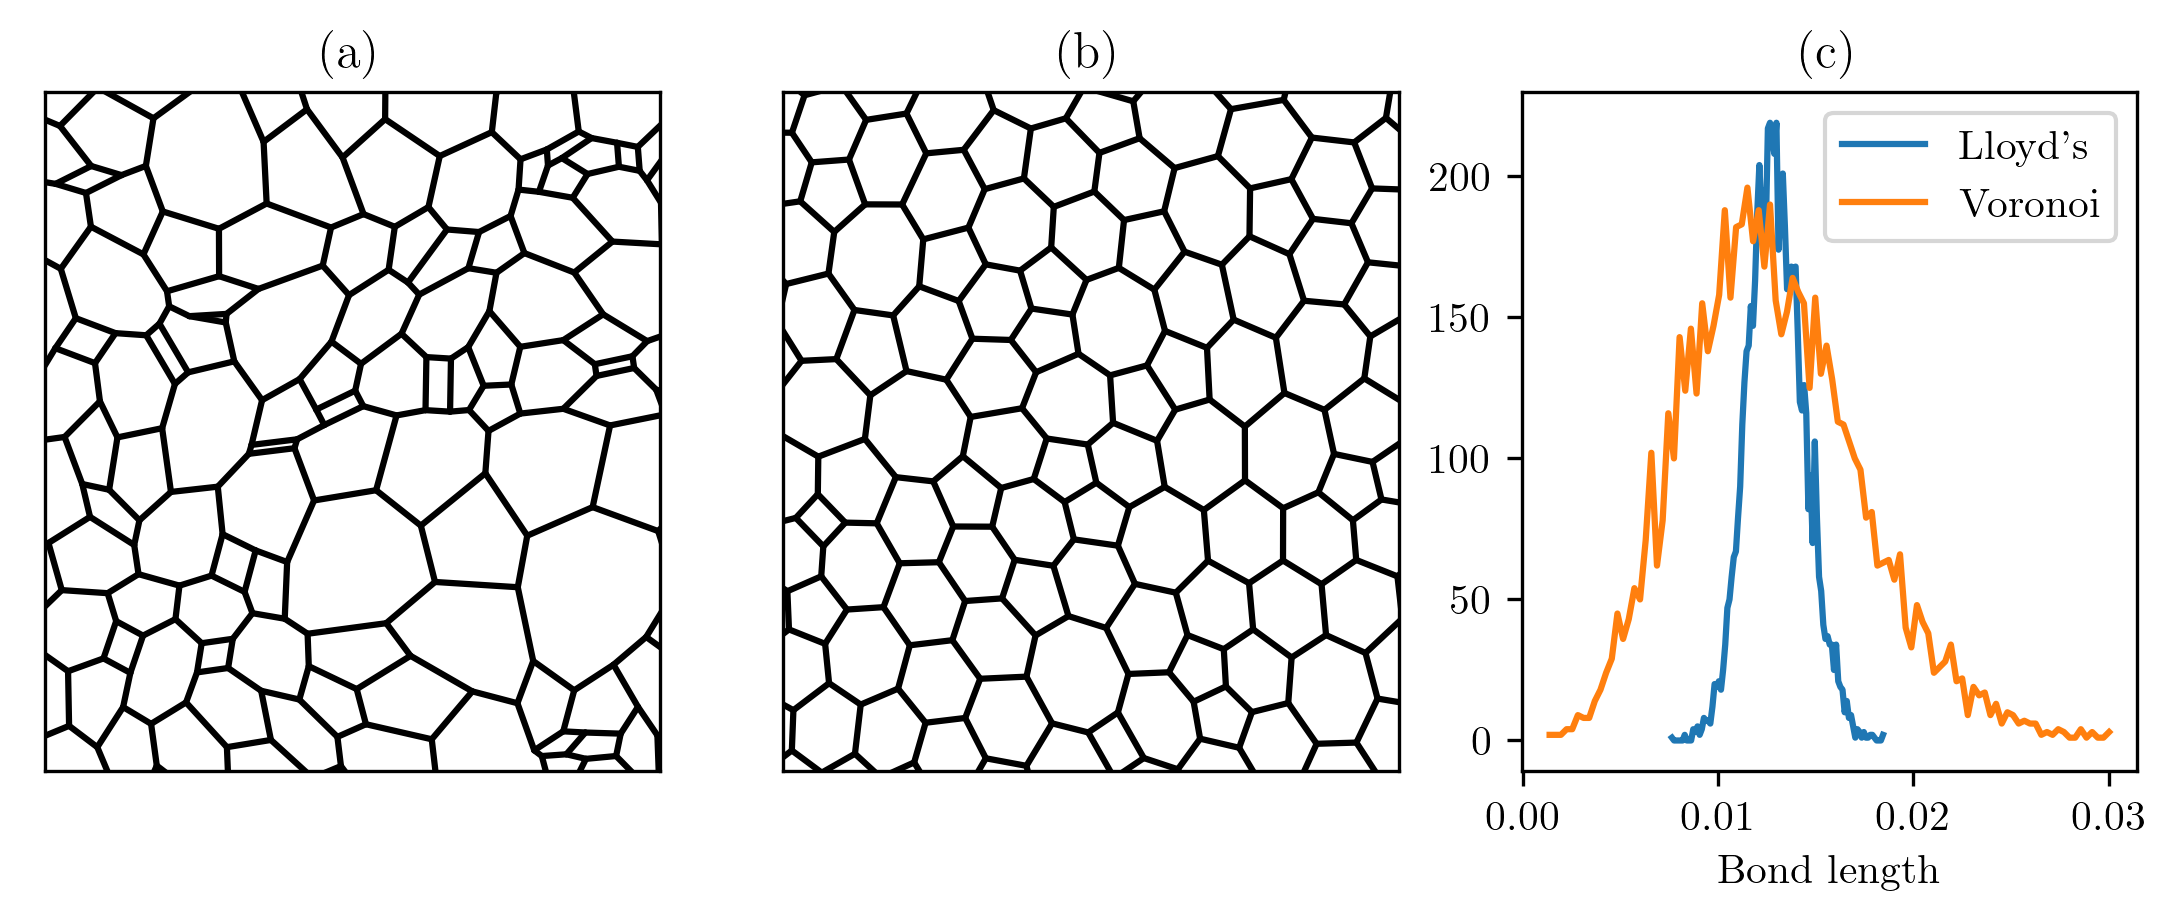

In [60]:


original_lattice = generate_lattice(uniform(len(points)), shift_vertices=True)

fig, ax = plt.subplots(1,3, figsize = (9,3), dpi = 300)

pl.plot_edges(original_lattice, ax= ax[0])
pl.plot_edges(lattice, ax= ax[1])

edge_length = np.sqrt(np.sum(lattice.edges.vectors**2, axis = 1))
hist, bs = np.histogram(edge_length, 100)
bs = 0.5*(bs[1:]+ bs[:-1])
ax[2].plot(bs,hist, label= "Lloyd's")
edge_length = np.sqrt(np.sum(original_lattice.edges.vectors**2, axis = 1))
hist, bs = np.histogram(edge_length, 100)
bs = 0.5*(bs[1:]+ bs[:-1])
ax[2].plot(bs,hist, label = 'Voronoi')

plt.legend()

ax[2].set_xlabel('Bond length')

ax[0].set_title('(a)')
ax[1].set_title('(b)')
ax[2].set_title('(c)')

ax[0].set_xlim([0.4,0.6])
ax[0].set_ylim([0.4,0.6])
ax[1].set_xlim([0.4,0.6])
ax[1].set_ylim([0.4,0.6])

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)



In [61]:
import numpy as np
import numpy.typing as npt
from koala.lattice import Lattice

def majorana_hamiltonian(
    lattice: Lattice,
    coloring: npt.NDArray,
    ujk: npt.NDArray,
    J: npt.NDArray[np.floating] = np.array([1.0, 1.0, 1.0]),
    power: float = 0
) -> npt.NDArray[np.complexfloating]:

    ham = np.zeros((lattice.n_vertices, lattice.n_vertices))
    Js = J[coloring] if coloring is not None else J[0]
    hoppings = 2 * Js * ujk

    bond_lengths = np.sqrt(np.sum(lattice.edges.vectors**2, axis= 1))
    if power == 0:
        scale = np.average(bond_lengths)
    else:
        scale = np.power(np.average(bond_lengths**power), 1/power)
    bond_lengths = bond_lengths/ scale

    ham[lattice.edges.indices[:, 1], lattice.edges.indices[:, 0]] = hoppings / (bond_lengths**power)
    ham[lattice.edges.indices[:, 0], lattice.edges.indices[:,1]] = -1 * hoppings / (bond_lengths**power)

    ham = ham * 1.0j / 4.0

    return ham



In [62]:
from koala.graph_color import color_lattice
from koala.flux_finder import ujk_from_fluxes

fluxes = np.array([-1]*lattice.n_plaquettes)
ujk = ujk_from_fluxes(lattice, fluxes)
J = np.array([1,1,1])
coloring = color_lattice(lattice)

hamiltonians = [majorana_hamiltonian(lattice, coloring, ujk, J, p)for p in np.arange(0,9,2)]

evs = [la.eigh(h) for h in hamiltonians]

energies = [np.average(np.abs(ev[0])) for ev in evs]
gaps = [np.min(np.abs(ev[0])) for ev in evs]


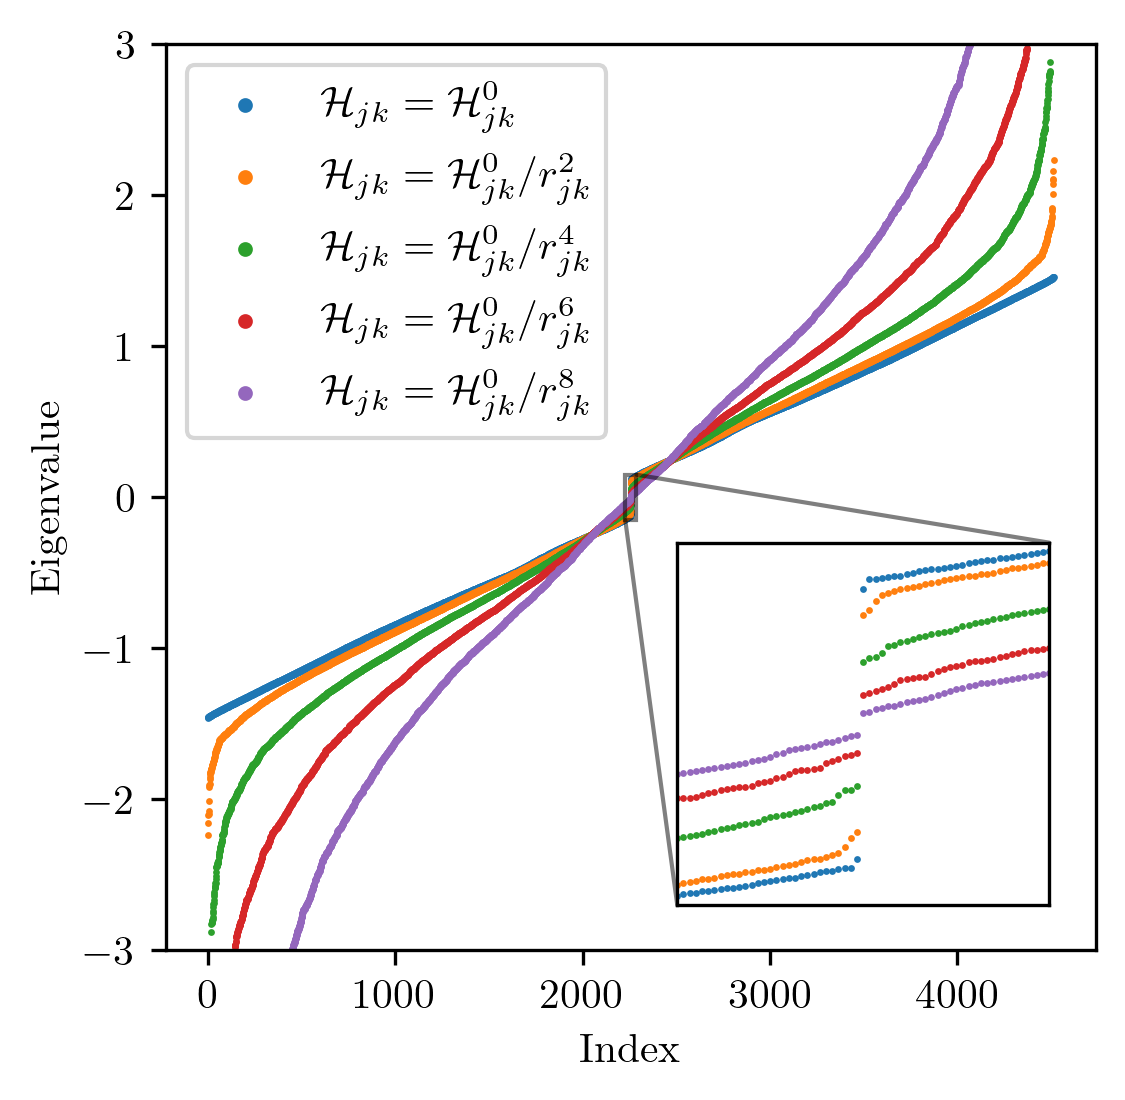

In [63]:
fig, ax = plt.subplots(figsize = (4,4), dpi = 300)

indices = np.arange(len(evs[0][0]))
for n in range(len(energies)):
    lab = r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk}$' if n == 0 else r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk} / r_{jk}^{' + f'{np.arange(0,9,2)[n]}' + '}$'
    ax.scatter(indices, evs[n][0],label=lab, s = 0.4)

ax.set_ylim(-3,3)

midpoint = len(evs[0][0]) //2

axins = ax.inset_axes([0.55, 0.05, 0.4, 0.4])
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])
for n in range(len(energies)):
    axins.scatter(indices, evs[n][0],label=r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk}$', s = 0.4)
axins.set_ylim([-0.15, 0.15])
axins.set_xlim([midpoint-30, midpoint+30])
ax.indicate_inset_zoom(axins, edgecolor='black')

ax.set_xlabel("Index")
ax.set_ylabel("Eigenvalue")
plt.legend(markerscale=4.)
# plt.tight_layout()


In [64]:
system_sizes = np.unique(np.logspace(.5, np.log10(80), 30, dtype=int))
k_values = np.round(np.sqrt(system_sizes))
num_samples = 50

all_minima = []
all_averages = []
all_maxima = []

for system_size in tqdm(system_sizes):
    
    running_total = np.zeros(np.arange(0,9,2).shape)
    minima = np.ones(np.arange(0,9,2).shape)*100
    maxima = np.zeros(np.arange(0,9,2).shape)

    for s in range(num_samples):
        points = bluenoise(20, system_size,system_size)
        lattice = generate_lattice(points)
        lattice = lloyd_relaxation(lattice, 4)

        # print(lattice.n_vertices)

        fluxes = np.array([-1]*lattice.n_plaquettes)
        ujk = ujk_from_fluxes(lattice, fluxes)
        J = np.array([1,1,1])
        coloring = color_lattice(lattice)

        hamiltonians = [majorana_hamiltonian(lattice, coloring, ujk, J, p)for p in np.arange(0,9,2)]

        energies = np.array([
            la.eigvalsh(h) for h in hamiltonians
        ])
        gaps = np.min(np.abs(energies), 1)
        running_total += gaps

        min_mask = gaps < minima
        max_mask = gaps > maxima

        minima = minima * (1- min_mask)
        minima = minima + min_mask*gaps

        maxima = maxima * (1- max_mask)
        maxima = maxima + max_mask*gaps

    average_gaps = running_total/num_samples

    all_minima.append(minima)
    all_averages.append(average_gaps)
    all_maxima.append(maxima)
all_minima = np.array(all_minima)
all_averages = np.array(all_averages)
all_maxima = np.array(all_maxima)

100%|██████████| 26/26 [11:05:38<00:00, 1536.10s/it] 


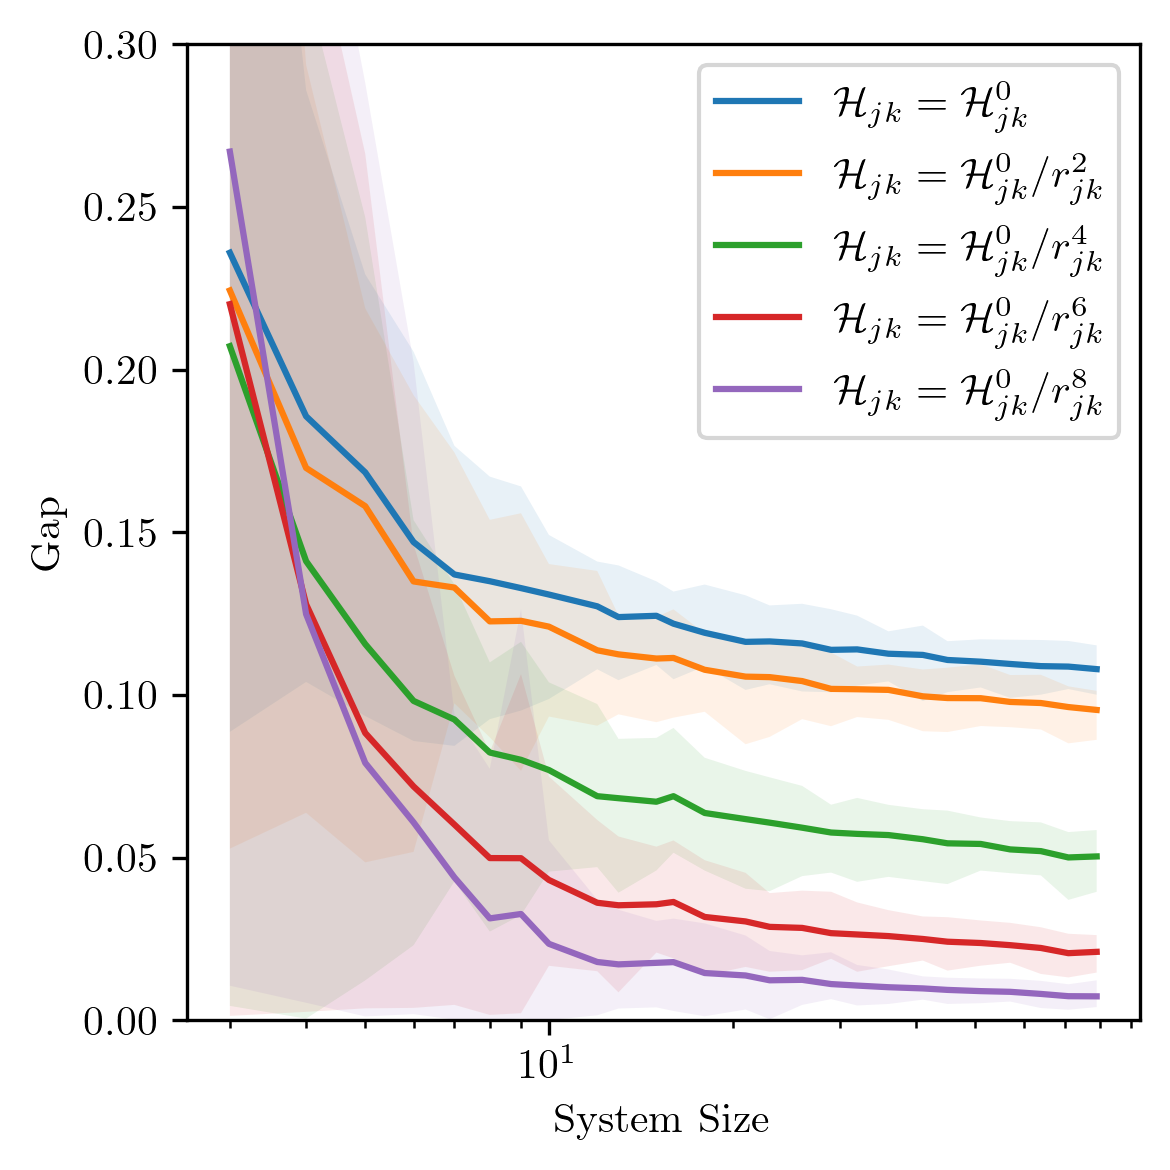

In [65]:
fig, ax = plt.subplots(figsize = (4,4), dpi = 300)
for n in range(len(np.arange(0,9,2))):
    lab = r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk}$' if n == 0 else r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk} / r_{jk}^{' + f'{np.arange(0,9,2)[n]}' + '}$'
    ax.plot(system_sizes[:len(all_minima)],all_averages[:,n], label = lab)
    ax.fill_between(system_sizes[:len(all_minima)], all_minima[:,n], all_maxima[:,n], alpha=0.1)


ax.set_ylim(0,0.3)
# ax.set_yscale('log')
ax.set_xscale('log')

plt.legend()
plt.xlabel("System Size")
plt.ylabel("Gap")
plt.tight_layout()
plt.savefig("size_scaling.pdf")
plt.savefig("size_scaling.png")

In [66]:
points = bluenoise(20, 60,60)
# points = bluenoise(2000)
lattice_for_diagram = generate_lattice(points)
from koala.graph_utils import lloyd_relaxation
lattice_for_diagram = lloyd_relaxation(lattice_for_diagram,4)

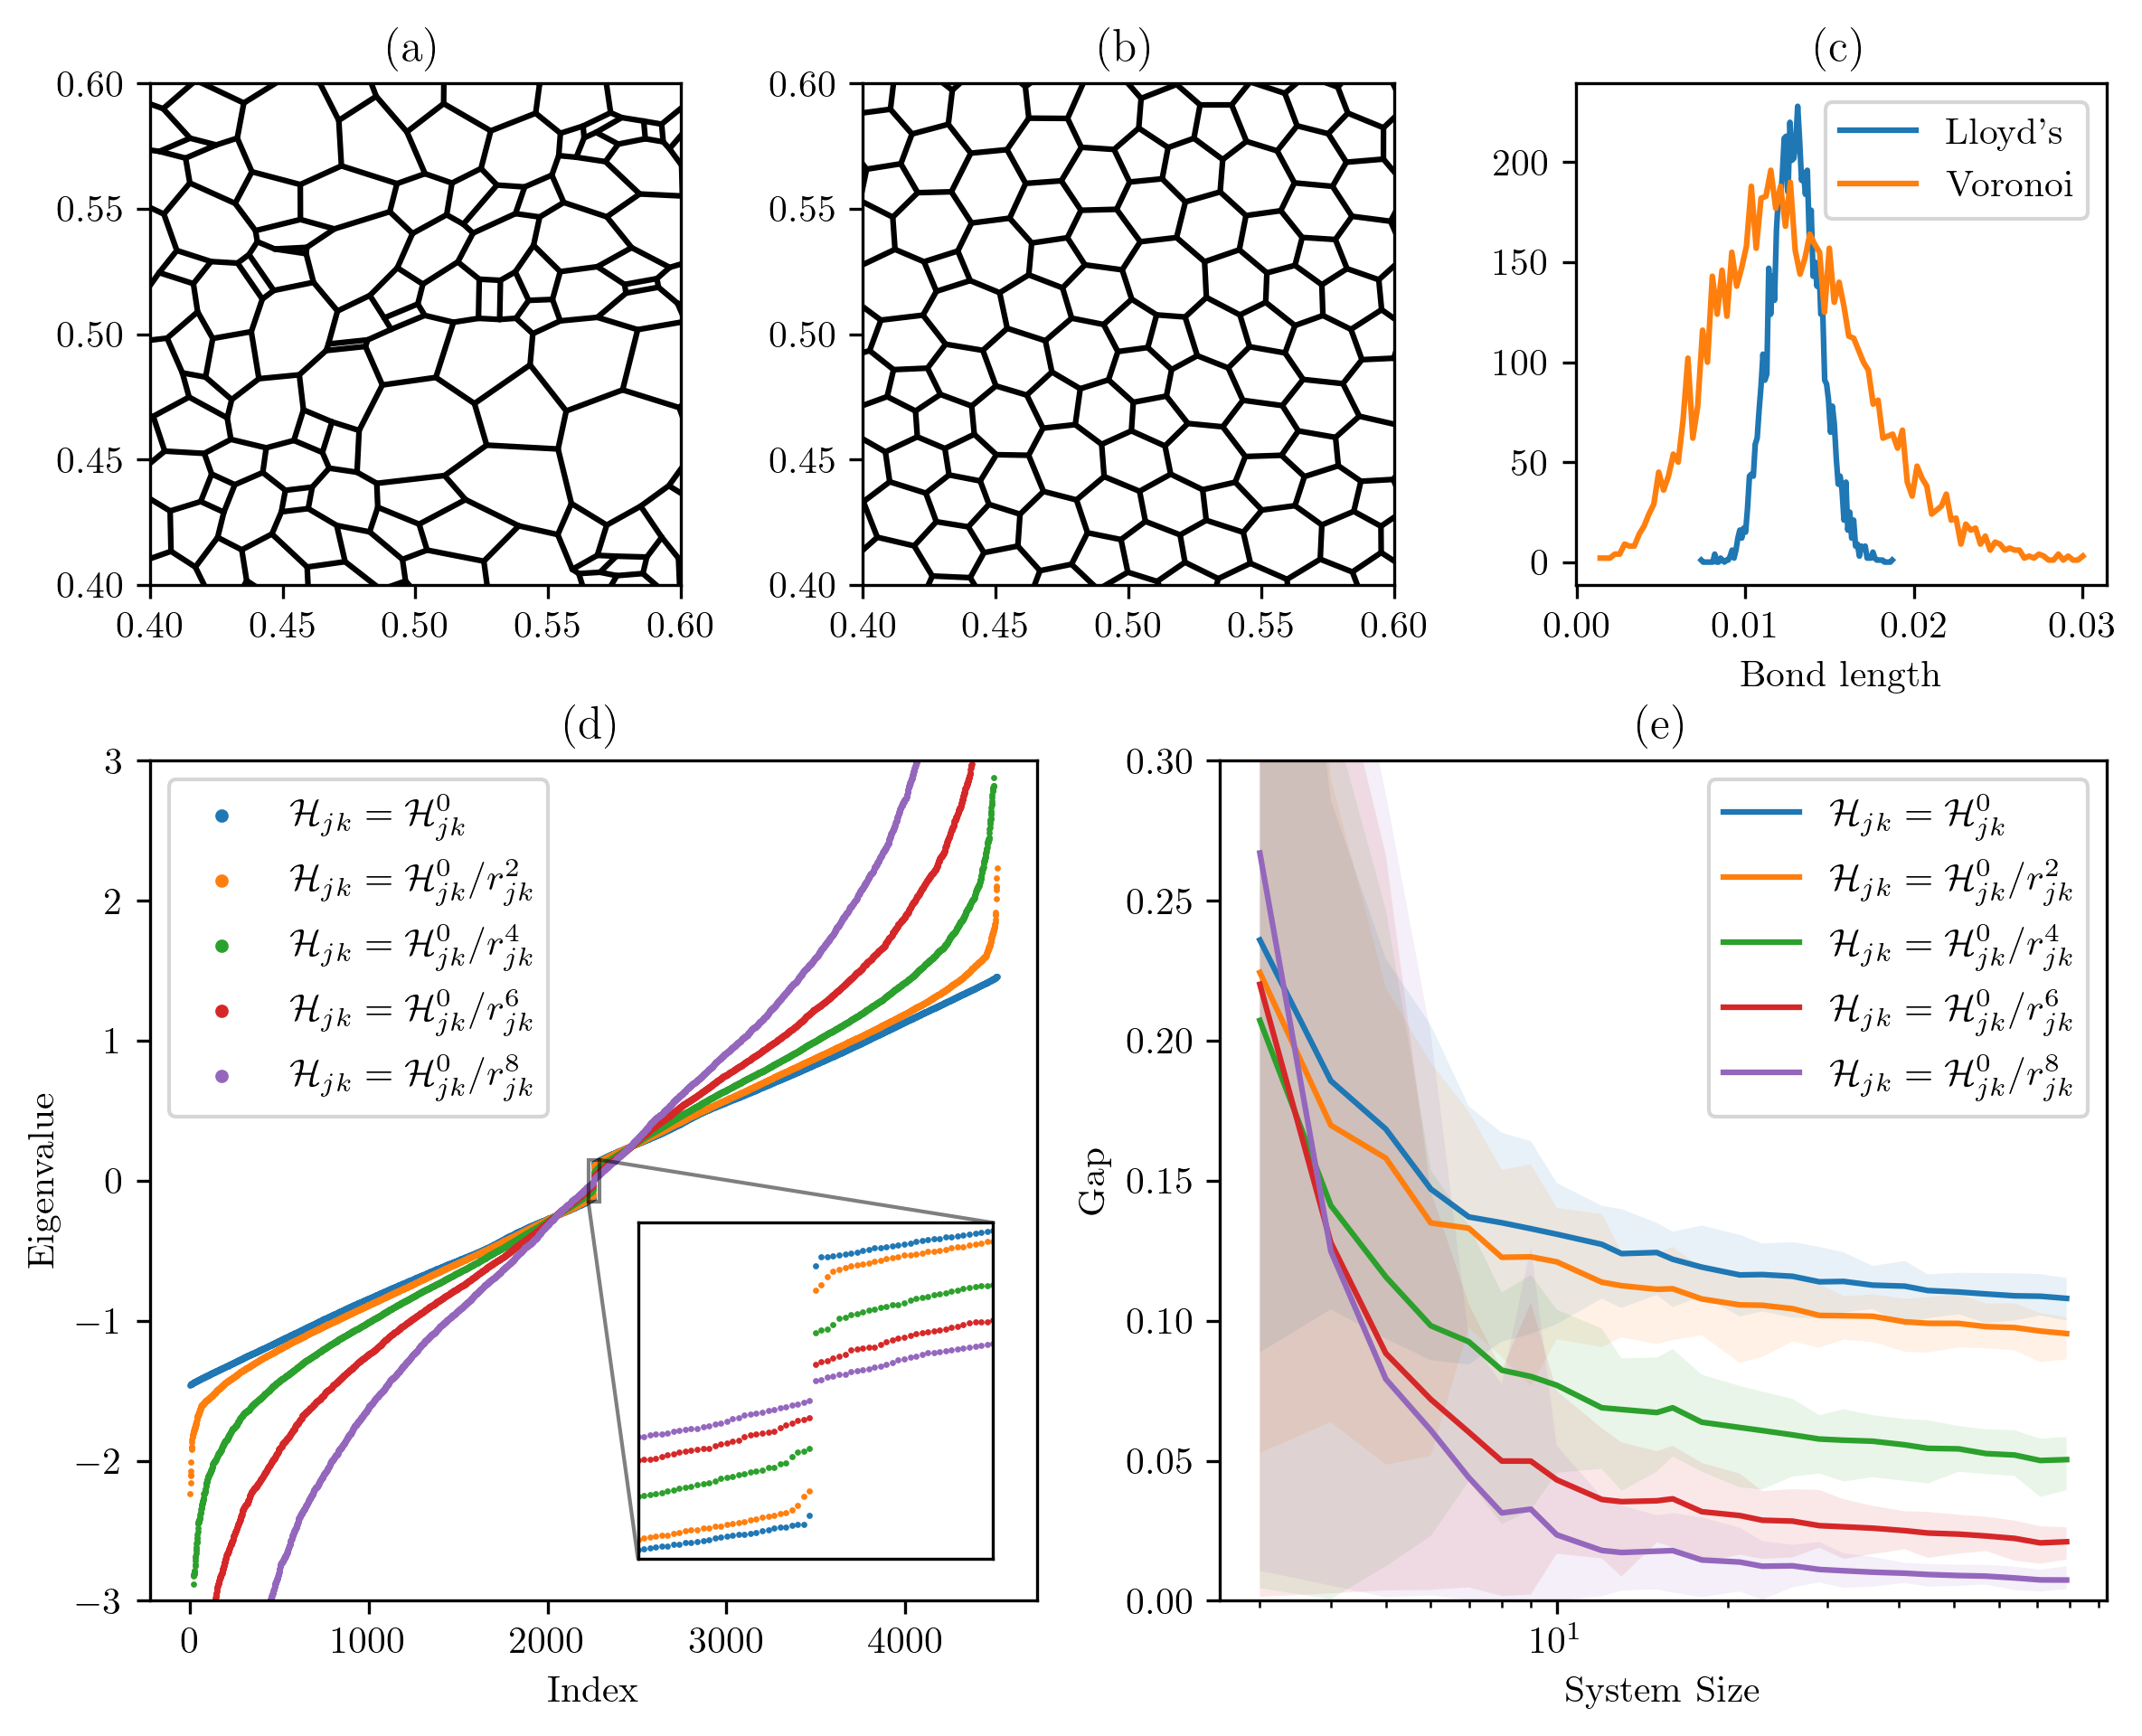

In [67]:
fig = plt.figure(figsize = (8,6.5), dpi = 300)

# ax = [
#     plt.subplot(2,3,1),
#     plt.subplot(2,3,2),
#     plt.subplot(2,3,3),
#     plt.subplot(2,2,3),
#     plt.subplot(2,2,4)
# ]

axes = fig.add_gridspec(5, 6)
ax1 = fig.add_subplot(axes[0:2, 0:2])
ax2 = fig.add_subplot(axes[0:2, 2:4])
ax3 = fig.add_subplot(axes[0:2, 4:6])
ax4 = fig.add_subplot(axes[2:5, 0:3])
ax5 = fig.add_subplot(axes[2:5, 3:6])

ax = [ax1,ax2,ax3,ax4,ax5]

# first three



pl.plot_edges(original_lattice, ax= ax[0])
pl.plot_edges(lattice_for_diagram, ax= ax[1])

edge_length = np.sqrt(np.sum(lattice_for_diagram.edges.vectors**2, axis = 1))
hist, bs = np.histogram(edge_length, 100)
bs = 0.5*(bs[1:]+ bs[:-1])
ax[2].plot(bs,hist, label= "Lloyd's")
edge_length = np.sqrt(np.sum(original_lattice.edges.vectors**2, axis = 1))
hist, bs = np.histogram(edge_length, 100)
bs = 0.5*(bs[1:]+ bs[:-1])
ax[2].plot(bs,hist, label = 'Voronoi')

ax[2].legend()

ax[2].set_xlabel('Bond length')

ax[0].set_title('(a)')
ax[1].set_title('(b)')
ax[2].set_title('(c)')

ax[0].set_xlim([0.4,0.6])
ax[0].set_ylim([0.4,0.6])
ax[1].set_xlim([0.4,0.6])
ax[1].set_ylim([0.4,0.6])

# ax[0].get_xaxis().set_visible(False)
# ax[0].get_yaxis().set_visible(False)
# ax[1].get_xaxis().set_visible(False)
# ax[1].get_yaxis().set_visible(False)




# second_one
indices = np.arange(len(evs[0][0]))
for n in range(len(energies)):
    lab = r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk}$' if n == 0 else r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk} / r_{jk}^{' + f'{np.arange(0,9,2)[n]}' + '}$'
    ax[3].scatter(indices, evs[n][0],label=lab, s = 0.4)

ax[3].set_ylim(-3,3)
ax[3].set_title('(d)')

midpoint = len(evs[0][0]) //2

axins = ax[3].inset_axes([0.55, 0.05, 0.4, 0.4])
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])
for n in range(len(energies)):
    axins.scatter(indices, evs[n][0],label=r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk}$', s = 0.4)
axins.set_ylim([-0.15, 0.15])
axins.set_xlim([midpoint-30, midpoint+30])
ax[3].indicate_inset_zoom(axins, edgecolor='black')

ax[3].set_xlabel("Index")
ax[3].set_ylabel("Eigenvalue")
ax[3].legend(markerscale=4.)
# plt.tight_layout()



# third one
ax[4].set_title('(e)')
for n in range(len(np.arange(0,9,2))):
    lab = r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk}$' if n == 0 else r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk} / r_{jk}^{' + f'{np.arange(0,9,2)[n]}' + '}$'
    ax[4].plot(system_sizes[:len(all_minima)],all_averages[:,n], label = lab)
    ax[4].fill_between(system_sizes[:len(all_minima)], all_minima[:,n], all_maxima[:,n], alpha=0.1)


ax[4].set_ylim(0,0.3)
# ax.set_yscale('log')
ax[4].set_xscale('log')

ax[4].legend()
ax[4].set_xlabel("System Size")
ax[4].set_ylabel("Gap")


plt.tight_layout(h_pad=.3)

plt.savefig("bond_disorder.pdf")
plt.savefig("bond_disorder.png")

In [68]:
# finally look at gap size for alpha value:

alpha_values = np.linspace(0,10, 30)
repeats = 10

running_total = np.zeros(alpha_values.shape)
minima = np.ones(alpha_values.shape)*100
maxima = np.zeros(alpha_values.shape)

for r in tqdm(range(repeats)):
    points = bluenoise(20, 50,50)
    # points = bluenoise(2000)
    lattice = generate_lattice(points)
    from koala.graph_utils import lloyd_relaxation
    lattice = lloyd_relaxation(lattice,4)

    fluxes = np.array([-1]*lattice.n_plaquettes)
    ujk = ujk_from_fluxes(lattice, fluxes)
    J = np.array([1,1,1])
    coloring = color_lattice(lattice) 

    hamiltonians = [majorana_hamiltonian(lattice, coloring, ujk, J, p)for p in alpha_values]

    energies = np.array([
        la.eigvalsh(h) for h in hamiltonians
    ])
    gaps = np.min(np.abs(energies), 1)
    running_total += gaps

    min_mask = gaps < minima
    max_mask = gaps > maxima

    minima = minima * (1- min_mask)
    minima = minima + min_mask*gaps

    maxima = maxima * (1- max_mask)
    maxima = maxima + max_mask*gaps

running_total = running_total/repeats

100%|██████████| 10/10 [21:39<00:00, 129.91s/it]


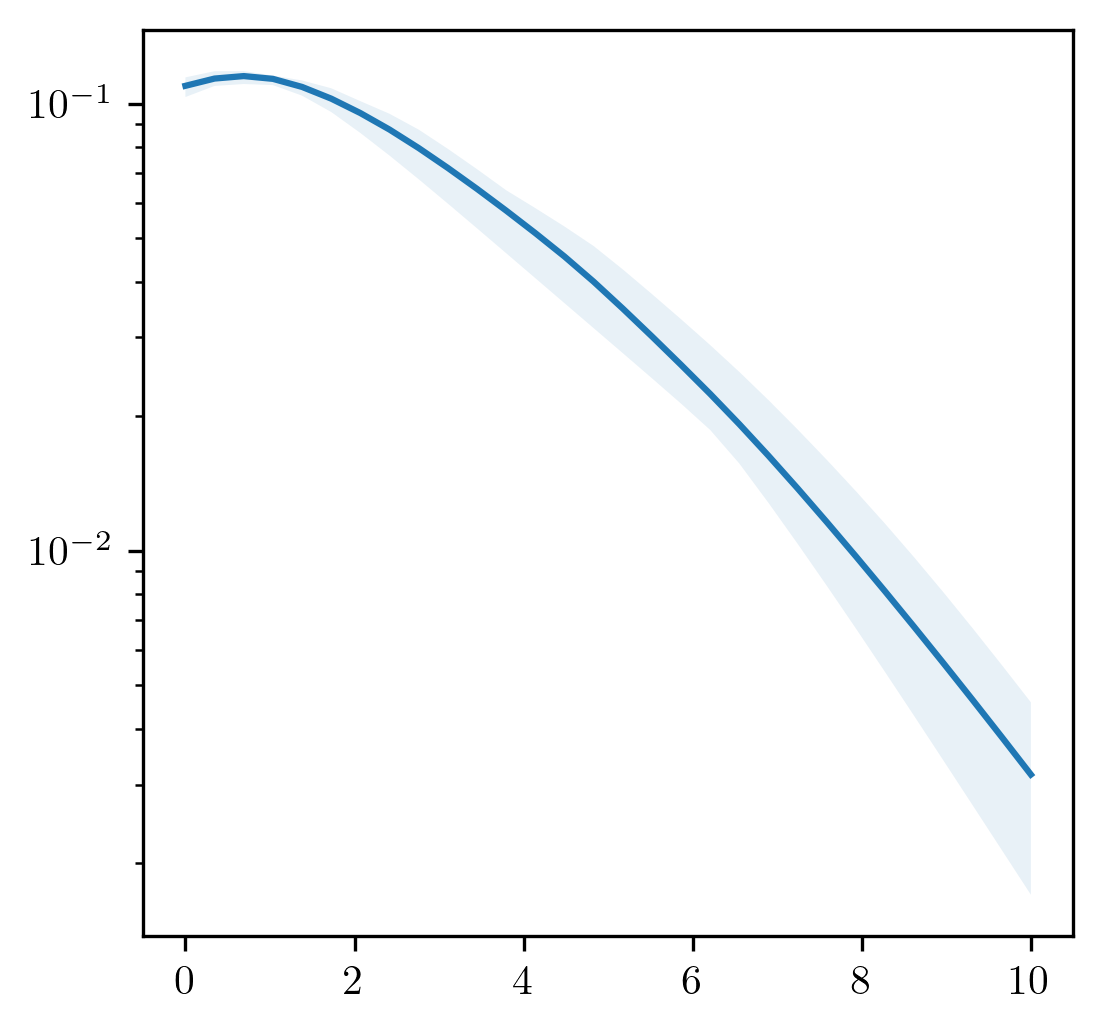

In [69]:
fig, ax = plt.subplots(figsize = (4,4), dpi = 300)

ax.plot(alpha_values,running_total)
ax.fill_between(alpha_values, minima, maxima, alpha=0.1)

ax.set_yscale('log')